# 07.1b: Sky Map with Tie-Aware Empirical CDF

**Goal:** Visualize token distribution using tie-aware empirical CDF to prevent artificial smearing of degenerate tokens.

**Key difference from 04.1a:** Instead of naive histogram equalization that assigns sequential ranks to all tokens (even tied ones), we use the tie-aware approach from 06.1w:

1. Sort tokens by latitude θ
2. Find **unique** θ values (grouping ties together)
3. Assign CDF percentiles to unique values only
4. Map all tokens in a tie group to the same flattened latitude

**Expected result:** Degenerate token clusters (identical θ) will appear as horizontal stripes at constant latitude, not vertically smeared.

## Parameters

In [19]:
TENSOR_DIR = "../data/tensors"

# Coordinate system: which PC axes define our spherical coordinates?
NORTH_PC = 1
MERIDIAN_PC = 2
EQUINOX_PC = 3

# Viewing direction
HEADING = 0

# Projection type: 'rectangular' or 'mollweide'
PROJECTION = 'rectangular'

# Zoom: set to None for full sky
LON_MIN = None
LON_MAX = None
LAT_MIN = None
LAT_MAX = None

# Mask out large degenerate cluster?
MASK_DEGENERATE = False  # Masks the 814-token singularity

# Visualization
POINT_SIZE = 1
POINT_ALPHA = 1
FIGURE_DPI = 100

## Imports

In [20]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data

In [21]:
# Load centered gamma prime
gamma_prime_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_prime = load_file(gamma_prime_path)['gamma_centered']

N, d = gamma_prime.shape

print(f"Loaded γ' (centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load jet mask
jet_mask_path = Path(TENSOR_DIR) / "jet_mask.safetensors"
jet_mask = load_file(jet_mask_path)['jet_mask']

n_jet = jet_mask.sum().item()
n_bulk = (~jet_mask).sum().item()

print(f"Loaded jet mask:")
print(f"  Jet tokens: {n_jet:,} ({n_jet/N*100:.2f}%)")
print(f"  Bulk tokens: {n_bulk:,} ({n_bulk/N*100:.2f}%)")
print()

# Create degenerate token mask
if MASK_DEGENERATE:
    print("Creating degenerate token mask...")
    ref_id = 149415
    reference = gamma_prime[ref_id]
    degenerate_mask = torch.all(gamma_prime == reference, dim=1)
    n_degenerate = degenerate_mask.sum().item()
    print(f"  Found {n_degenerate:,} degenerate tokens ({n_degenerate/N*100:.4f}%)")
    print(f"  These will be excluded from the plot.")
else:
    degenerate_mask = torch.zeros(N, dtype=torch.bool)
    n_degenerate = 0
    print("Degenerate masking disabled.")

Loaded γ' (centered):
  Tokens: 151,936
  Dimensions: 2,560

Loaded jet mask:
  Jet tokens: 3,055 (2.01%)
  Bulk tokens: 148,881 (97.99%)

Degenerate masking disabled.


## Step 2: Compute PCA

In [22]:
print("Computing covariance matrix...")
Cov = (gamma_prime.T @ gamma_prime) / (N - 1)

print(f"Covariance matrix shape: {Cov.shape}")
print(f"Computing eigendecomposition...\n")

eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues:")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}%)")

print(f"\nPCA computed successfully.")

Computing covariance matrix...
Covariance matrix shape: torch.Size([2560, 2560])
Computing eigendecomposition...

Top 10 eigenvalues:
  PC1: λ = 1.048719e-02 (0.94%)
  PC2: λ = 3.177739e-03 (0.28%)
  PC3: λ = 2.791374e-03 (0.25%)
  PC4: λ = 2.616169e-03 (0.23%)
  PC5: λ = 1.973001e-03 (0.18%)
  PC6: λ = 1.805293e-03 (0.16%)
  PC7: λ = 1.609086e-03 (0.14%)
  PC8: λ = 1.549411e-03 (0.14%)
  PC9: λ = 1.468294e-03 (0.13%)
  PC10: λ = 1.389096e-03 (0.12%)

PCA computed successfully.


## Step 3: Define Coordinate System

In [23]:
# Extract basis vectors
north_vector = eigenvectors[:, NORTH_PC - 1]
meridian_vector = eigenvectors[:, MERIDIAN_PC - 1]
equinox_vector = eigenvectors[:, EQUINOX_PC - 1]

print(f"Coordinate system:")
print(f"  North pole: PC{NORTH_PC}")
print(f"  Prime meridian: PC{MERIDIAN_PC}")
print(f"  Equinox: PC{EQUINOX_PC}")
print()

# Verify orthonormality
dot_nm = (north_vector @ meridian_vector).item()
dot_ne = (north_vector @ equinox_vector).item()
dot_me = (meridian_vector @ equinox_vector).item()

print(f"Orthogonality check (should all be ~0):")
print(f"  North · Meridian: {dot_nm:.6f}")
print(f"  North · Equinox: {dot_ne:.6f}")
print(f"  Meridian · Equinox: {dot_me:.6f}")
print()

norm_n = north_vector.norm().item()
norm_m = meridian_vector.norm().item()
norm_e = equinox_vector.norm().item()

print(f"Normalization check (should all be ~1):")
print(f"  ||North||: {norm_n:.6f}")
print(f"  ||Meridian||: {norm_m:.6f}")
print(f"  ||Equinox||: {norm_e:.6f}")

Coordinate system:
  North pole: PC1
  Prime meridian: PC2
  Equinox: PC3

Orthogonality check (should all be ~0):
  North · Meridian: 0.000000
  North · Equinox: 0.000000
  Meridian · Equinox: 0.000000

Normalization check (should all be ~1):
  ||North||: 1.000000
  ||Meridian||: 0.999999
  ||Equinox||: 1.000000


## Step 4: Convert to Spherical Coordinates

Standard spherical conversion:
- Latitude θ: [-90°, +90°]
- Longitude φ: [-180°, +180°]

In [24]:
print(f"Converting {N:,} tokens to spherical coordinates...\n")

# Project onto basis vectors
x = gamma_prime @ meridian_vector
y = gamma_prime @ equinox_vector
z = gamma_prime @ north_vector

# Compute radius
r = torch.sqrt(x**2 + y**2 + z**2)

# Latitude: arcsin(z/r)
theta_rad = torch.asin(torch.clamp(z / r, -1, 1))
theta_deg = torch.rad2deg(theta_rad)

# Longitude: atan2(y, x)
phi_rad = torch.atan2(y, x)
phi_deg = torch.rad2deg(phi_rad)

print(f"Spherical coordinates computed.")
print()
print(f"Latitude statistics (before CDF transform):")
print(f"  Mean: {theta_deg.mean().item():.6f}°")
print(f"  Std: {theta_deg.std().item():.6f}°")
print(f"  Min: {theta_deg.min().item():.6f}°")
print(f"  Max: {theta_deg.max().item():.6f}°")

Converting 151,936 tokens to spherical coordinates...

Spherical coordinates computed.

Latitude statistics (before CDF transform):
  Mean: 5.255265°
  Std: 49.628139°
  Min: -89.923386°
  Max: 89.680405°


## Step 5: Apply Tie-Aware Empirical CDF Transform

**Tie-aware algorithm (from 06.1w):**

1. Sort all latitudes
2. Find unique latitude values and their inverse mapping
3. Assign CDF percentiles to **unique** values only
4. Map all tokens back via inverse indices

This ensures that tokens with identical θ (tied values) get mapped to the same flattened latitude, appearing as horizontal stripes instead of vertical smears.

In [25]:
print("Applying tie-aware empirical CDF transform...\n")

# Sort by theta
theta_sorted, sort_indices = torch.sort(theta_deg)

# Find unique theta values and their inverse mapping
unique_theta, inverse_indices = torch.unique(theta_sorted, return_inverse=True)

n_unique = len(unique_theta)
print(f"Found {n_unique:,} unique latitude values (out of {N:,} tokens)")
print(f"  Average cluster size: {N / n_unique:.2f} tokens per unique value")
print()

# Assign CDF values based on unique theta values only
cdf_values_unique = torch.linspace(0, 1, n_unique)

# Map to [-90°, +90°]
theta_flat_unique = 90.0 * (2.0 * cdf_values_unique - 1.0)

# Map back to all tokens via inverse indices
# All tokens with same theta → same flattened latitude
theta_flat_sorted = theta_flat_unique[inverse_indices]

# Unsort to original token order
theta_flat = torch.zeros_like(theta_deg)
theta_flat[sort_indices] = theta_flat_sorted

print(f"Tie-aware CDF transform complete.")
print()
print(f"Transformed latitude statistics:")
print(f"  Mean: {theta_flat.mean().item():.6f}°")
print(f"  Std: {theta_flat.std().item():.6f}°")
print(f"  Min: {theta_flat.min().item():.6f}°")
print(f"  Max: {theta_flat.max().item():.6f}°")
print(f"  Unique values: {len(torch.unique(theta_flat)):,}")

Applying tie-aware empirical CDF transform...

Found 149,283 unique latitude values (out of 151,936 tokens)
  Average cluster size: 1.02 tokens per unique value

Tie-aware CDF transform complete.

Transformed latitude statistics:
  Mean: 0.143390°
  Std: 51.666084°
  Min: -90.000000°
  Max: 90.000000°
  Unique values: 149,283


## Step 6: Apply Heading Rotation

In [26]:
# Shift longitude by HEADING
phi_rotated = phi_deg - HEADING

# Wrap to [-180°, +180°]
phi_rotated = torch.where(phi_rotated > 180, phi_rotated - 360, phi_rotated)
phi_rotated = torch.where(phi_rotated < -180, phi_rotated + 360, phi_rotated)

print(f"Applied heading rotation: {HEADING}°")

Applied heading rotation: 0°


## Step 7: Create Sky Map with Tie-Aware CDF

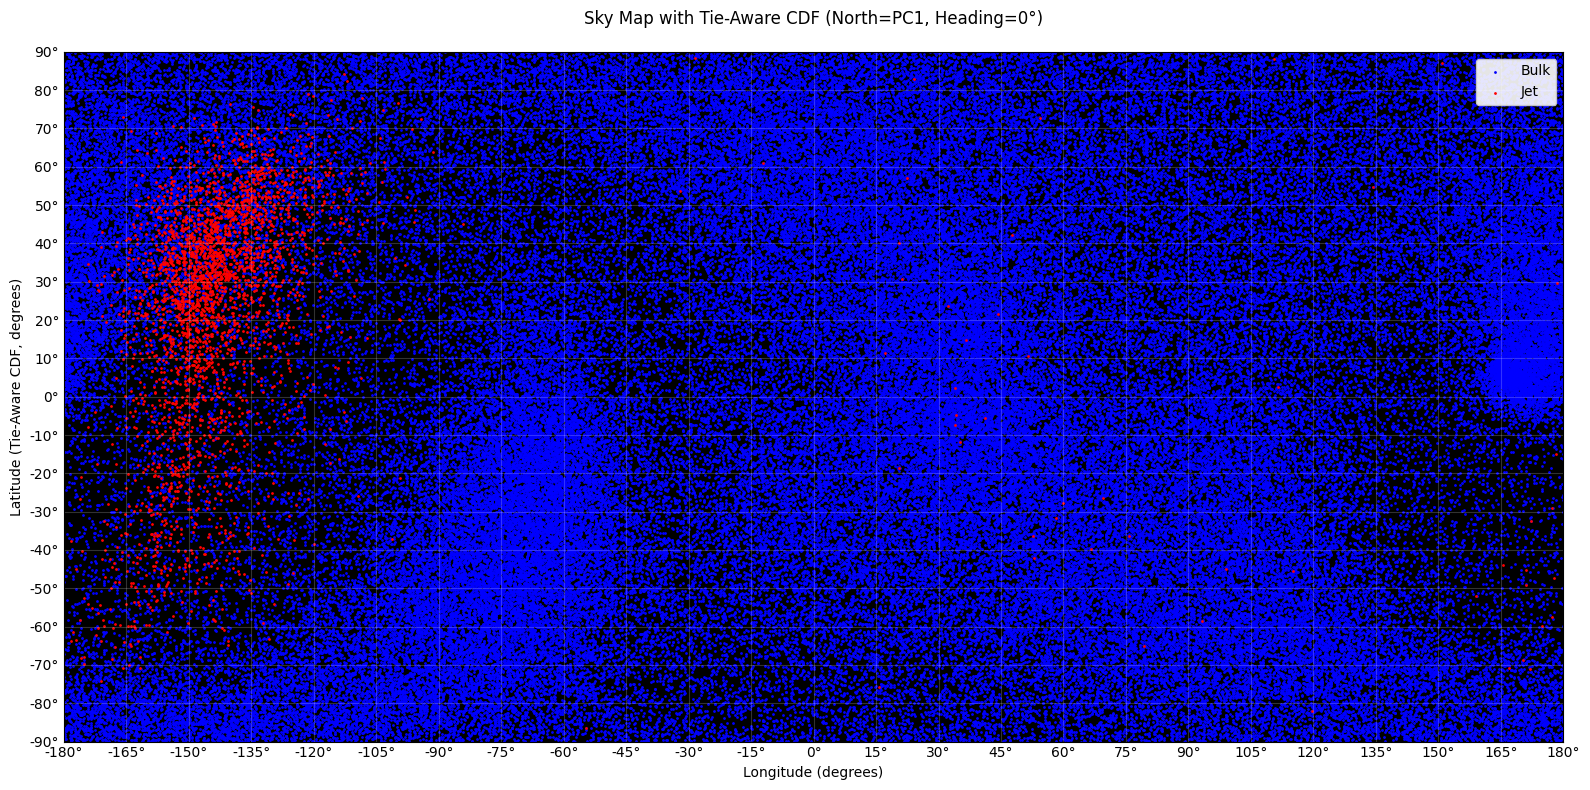


Sky map complete (rectangular projection with tie-aware CDF).
  Total points plotted: 151,936 (of 151,936 total)
  Jet points: 3,055 (red)
  Bulk points: 148,881 (blue)


In [27]:
# Create plot mask
plot_mask = ~degenerate_mask

# Convert to numpy
phi_rotated_np = phi_rotated.cpu().numpy()
theta_flat_np = theta_flat.cpu().numpy()
jet_mask_np = jet_mask.cpu().numpy()
plot_mask_np = plot_mask.cpu().numpy()

# Apply mask
phi_plot = phi_rotated_np[plot_mask_np]
theta_plot = theta_flat_np[plot_mask_np]
jet_plot = jet_mask_np[plot_mask_np]

# Convert to radians for Mollweide
phi_plot_rad = np.deg2rad(phi_plot)
theta_plot_rad = np.deg2rad(theta_plot)

n_plotted = len(phi_plot)
n_jet_plotted = jet_plot.sum()
n_bulk_plotted = (~jet_plot).sum()

# Create figure
if PROJECTION == 'mollweide':
    fig = plt.figure(figsize=(16, 8), dpi=FIGURE_DPI)
    ax = fig.add_subplot(111, projection='mollweide')
    ax.set_facecolor('black')
    
    ax.scatter(phi_plot_rad[~jet_plot], theta_plot_rad[~jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)
    ax.scatter(phi_plot_rad[jet_plot], theta_plot_rad[jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='red', label='Jet', rasterized=True)
    
    ax.grid(True, alpha=0.2, color='white')
    ax.tick_params(axis='both', which='both', length=0, colors='black')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
else:  # rectangular
    fig, ax = plt.subplots(figsize=(16, 8), dpi=FIGURE_DPI)
    ax.set_facecolor('black')
    
    ax.scatter(phi_plot[~jet_plot], theta_plot[~jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='blue', label='Bulk', rasterized=True)
    ax.scatter(phi_plot[jet_plot], theta_plot[jet_plot],
               s=POINT_SIZE, alpha=POINT_ALPHA, c='red', label='Jet', rasterized=True)
    
    # Determine limits
    lon_min = LON_MIN if LON_MIN is not None else -180
    lon_max = LON_MAX if LON_MAX is not None else 180
    lat_min = LAT_MIN if LAT_MIN is not None else -90
    lat_max = LAT_MAX if LAT_MAX is not None else 90
    
    lon_range = lon_max - lon_min
    lat_range = lat_max - lat_min
    
    # Tick spacing
    if lon_range <= 20:
        lon_tick_spacing = 1
    elif lon_range <= 60:
        lon_tick_spacing = 5
    else:
        lon_tick_spacing = 15
    
    if lat_range <= 20:
        lat_tick_spacing = 1
    elif lat_range <= 60:
        lat_tick_spacing = 5
    else:
        lat_tick_spacing = 10
    
    lon_ticks = np.arange(
        np.ceil(lon_min / lon_tick_spacing) * lon_tick_spacing,
        lon_max + lon_tick_spacing,
        lon_tick_spacing
    )
    lat_ticks = np.arange(
        np.ceil(lat_min / lat_tick_spacing) * lat_tick_spacing,
        lat_max + lat_tick_spacing,
        lat_tick_spacing
    )
    
    ax.set_xticks(lon_ticks)
    ax.set_yticks(lat_ticks)
    ax.set_xticklabels([f'{int(lon)}°' for lon in lon_ticks])
    ax.set_yticklabels([f'{int(lat)}°' for lat in lat_ticks])
    ax.tick_params(axis='both', which='both', length=0, colors='black')
    
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)
    ax.grid(True, alpha=0.2, color='white', which='major')

# Common formatting
ax.set_xlabel('Longitude (degrees)', color='black')
ax.set_ylabel('Latitude (Tie-Aware CDF, degrees)', color='black')

if PROJECTION == 'rectangular' and (LON_MIN is not None or LAT_MIN is not None):
    title = f'Sky Map with Tie-Aware CDF (North=PC{NORTH_PC}, Heading={HEADING}°)\n'
    title += f'Zoom: Lon [{lon_min}°, {lon_max}°], Lat [{lat_min}°, {lat_max}°]'
else:
    title = f'Sky Map with Tie-Aware CDF (North=PC{NORTH_PC}, Heading={HEADING}°)'

if MASK_DEGENERATE:
    title += f' [Large degenerate cluster masked]'

ax.set_title(title, color='black', pad=20)
for spine in ax.spines.values():
    spine.set_edgecolor('black')

legend = ax.legend(loc='upper right', framealpha=0.9)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nSky map complete ({PROJECTION} projection with tie-aware CDF).")
if PROJECTION == 'rectangular' and (LON_MIN is not None or LAT_MIN is not None):
    print(f"  Zoom: Longitude [{lon_min}°, {lon_max}°], Latitude [{lat_min}°, {lat_max}°]")
print(f"  Total points plotted: {n_plotted:,} (of {N:,} total)")
if MASK_DEGENERATE:
    print(f"  Masked out: {n_degenerate:,} degenerate tokens")
print(f"  Jet points: {n_jet_plotted:,} (red)")
print(f"  Bulk points: {n_bulk_plotted:,} (blue)")

## Summary

We visualized the token distribution using **tie-aware empirical CDF** to preserve degeneracy structure.

**Key differences from naive CDF:**
- **Naive CDF (04.1a):** Assigns sequential ranks to all tokens, even those with identical θ → artificially spreads degenerate clusters vertically
- **Tie-aware CDF (this notebook):** Groups identical θ values together → all tokens in a degenerate cluster map to the same flattened latitude → appear as horizontal stripes

**Interpretation:**
- Horizontal stripes = tokens with identical latitude in the original projection
- If we see many thin evenly-spaced stripes → many small degenerate clusters throughout the distribution
- Compare with 04.1a to see what vertical structure was artificial smearing vs. real geometric variation